In [115]:
import pandas as pd
from datetime import datetime, timedelta, date
import io

colorado_df = pd.read_csv("data/states/colorado/colorado.csv", error_bad_lines=True)
colorado_df = colorado_df[(colorado_df['occcounty'] < 8999)]

county_pop_df = pd.read_csv("data/states/county_pop.csv", encoding = "utf-8",error_bad_lines=True)
county_pop_df = county_pop_df[county_pop_df['STNAME'] == 'Colorado']

#yearly_deaths_by_code = weekly_deaths_df[(weekly_deaths_df['week'] <= 34) & (weekly_deaths_df['year'] == 2019)].groupby(['ucod'])['total_deaths'].sum()
#yearly_deaths_by_code_df = yearly_deaths_by_code.to_frame(name = 'yearly_deaths').sort_values(['yearly_deaths', 'ucod'],ascending=False).reset_index().head(26)
#top_ucodes = yearly_deaths_by_code_df['ucod']
#weekly_deaths_df= weekly_deaths_df[(weekly_deaths_df['ucod'].isin(top_ucodes))]

pulm_categories =['J449','I251','C349','I219','I500','I250','I64','I119','I48','F019','I110','J189']
non_pulm_categories =['G309','F03','C259','C509','G20','C61','C189','K703','W19','X70','C80','X74','A419','X44']
top_ucodes = pulm_categories + non_pulm_categories

colorado_df['cat'] = ''
colorado_df.loc[colorado_df['ucod'].isin(pulm_categories), "cat"] = 'P'
colorado_df.loc[colorado_df['acme2'].isin(pulm_categories), "cat"] = 'P'
colorado_df.loc[colorado_df['ucod'].isin(non_pulm_categories), "cat"] = 'NP'
colorado_df.loc[colorado_df['acme2'].isin(non_pulm_categories), "cat"] = 'NP'

colorado_df = colorado_df[(colorado_df['ucod'].isin(top_ucodes) | (colorado_df['acme2'].isin(top_ucodes)))]

weekly_deaths_df = colorado_df.groupby(['occcounty', 'year','dwk','cat'])['deaths'].agg(['sum']).reset_index()
weekly_deaths_df = weekly_deaths_df.rename(columns={'occcounty':'county','dwk' : 'week', 'sum':'total_deaths'})


county_2017_pop= dict(zip(county_pop_df.COUNTY,county_pop_df.POPESTIMATE2017))
pop_100k = 100000.0
weekly_deaths_df['pop'] = 0
weekly_deaths_df['total_deaths_per100k'] = 0
weekly_deaths_df['excess_deaths_per100k'] = 0
for index, row in weekly_deaths_df.iterrows():
    county = row['county'] - 8000
    weekly_deaths_df.at[index,'pop'] = county_2017_pop[county]
    weekly_deaths_df.at[index, 'total_deaths_per100k'] = row["total_deaths"] #(row["total_deaths"] *pop_100k )/(county_2017_pop[county]* 1.0)


avg_deaths = weekly_deaths_df[weekly_deaths_df['year'] < 2020].groupby(['county', 'week','cat'])['total_deaths_per100k'].mean()
avg_deaths_df = avg_deaths.to_frame(name = 'avg_deaths').reset_index()

for index, row in weekly_deaths_df.iterrows():
    year = row['year']
    county = row['county']
    week = row['week']
    cat = row['cat']
    if year == 2020:
        avgd = avg_deaths_df[(avg_deaths_df['county'] == county) & (avg_deaths_df['week'] == week) & (avg_deaths_df['cat'] == cat)]
        if not avgd.empty:
            weekly_deaths_df.at[index, "excess_deaths_per100k"] = row['total_deaths_per100k'] - avgd['avg_deaths']      
weekly_deaths_df["county"] = pd.to_numeric(weekly_deaths_df["county"], downcast='float')


 

In [116]:
weekly_deaths_df = weekly_deaths_df[(weekly_deaths_df['year'] ==2020) & (weekly_deaths_df['cat'] == 'NP') & (weekly_deaths_df['week'] <= 30)]
weekly_deaths_df[(weekly_deaths_df['year'] ==2020) ].groupby('year')['total_deaths_per100k'].sum()

year
2020    7877
Name: total_deaths_per100k, dtype: int64

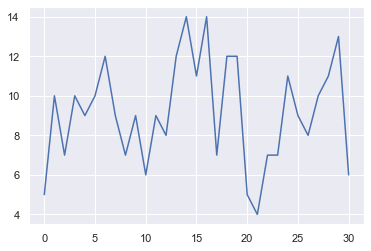

In [117]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
x = weekly_deaths_df[(weekly_deaths_df['year'] ==2020) &(weekly_deaths_df['county'] == 8123)]['week']
y = weekly_deaths_df[(weekly_deaths_df['year'] ==2020) &(weekly_deaths_df['county'] == 8123)]['total_deaths_per100k']
plt.plot(x, y)

In [118]:
Confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
US_Cases_df = pd.read_csv(Confirmed_url, error_bad_lines=True)
US_Cases_df=US_Cases_df.drop(columns=['UID','iso2','iso3','code3','Admin2',  'Country_Region','Lat','Long_','Combined_Key'])
US_Cases_df=US_Cases_df.fillna(0)#US_Cases_df.dropna(subset=['FIPS'])

US_Cases_df = US_Cases_df[US_Cases_df['Province_State'] == 'Colorado']
US_Cases_df=US_Cases_df.melt(id_vars=['FIPS','Province_State'], 
        var_name="Date", 
        value_name="Value")

US_Cases_df['Date']= pd.to_datetime(US_Cases_df['Date'])
US_Cases_df['week'] = US_Cases_df['Date'].dt.week
weekly_cases_df = US_Cases_df.groupby(['FIPS', 'week'])['Value'].sum()
weekly_cases_df = weekly_cases_df.to_frame(name = 'weekly_cases').reset_index()


In [119]:

county_covariates= pd.read_csv('https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/counties.csv').dropna(subset=['FIPS'])
county_covariates = county_covariates[county_covariates['State'] == 'CO']
county_covariates.FIPS = county_covariates.FIPS.astype('int64')
county_covariates=county_covariates.set_index('FIPS')
age_race_df = pd.read_csv('https://docs.google.com/spreadsheets/d/12GIRONjeNHeKFb3EKpo5r-VvdsnTwwe0iOtKBsnZVM0/export?format=csv')
county_icu_beds= pd.read_csv('https://docs.google.com/spreadsheets/d/13iUBUwRcE91_x9FhsF8Ugcb0_tFauWJF2Z-PSkERDlU/export?format=csv')
FIPS = pd.read_csv('https://docs.google.com/spreadsheets/d/1jUwRaTSJ__3Wp60cZLLox5u55mJTZrShtjEK4d7xTEY/export?format=csv')
covariates = age_race_df.merge(county_covariates, how='inner', left_on=["fips"], right_on=['FIPS'])
covariates = covariates.drop(['STNAME', 'County', 'Unnamed: 0','State', 'Area_Name'], axis=1)
covariates = covariates.merge(county_icu_beds, how='inner', left_on=["fips"], right_on=['fips'])
covariates = covariates.drop(['County','State'], axis=1)
covariates = covariates.fillna(0)

covariates = covariates.dropna(axis='columns')

covariates=covariates[['fips',
 'TOT_POP',
 '0-9',
 '0-9 y/o % of total pop',
 '10-19',
 '10-19 y/o % of total pop',
 '20-29',
 '20-29 y/o % of total pop',
 '30-39',
 '30-39 y/o % of total pop',
 '40-49',
 '40-49 y/o % of total pop',
 '50-59',
 '50-59 y/o % of total pop',
 '60-69',
 '60-69 y/o % of total pop',
 '70-79',
 '70-79 y/o % of total pop',
 '80+',
 '80+ y/o % of total pop',
 'White-alone pop',
 '% White-alone',
 'Black-alone pop',
 '% Black-alone',
 'Native American/American Indian-alone pop',
 '% NA/AI-alone',
 'Asian-alone pop',
 '% Asian-alone',
 'Hawaiian/Pacific Islander-alone pop',
 '% Hawaiian/PI-alone',
 'Two or more races pop',
 '% Two or more races',
 'POP_ESTIMATE_2018',
 'N_POP_CHG_2018',
 'GQ_ESTIMATES_2018',
 'R_birth_2018',
 'R_death_2018',
 'R_NATURAL_INC_2018',
 'R_INTERNATIONAL_MIG_2018',
 'R_DOMESTIC_MIG_2018',
 'R_NET_MIG_2018',
 'Less than a high school diploma 2014-18',
 'High school diploma only 2014-18',
 "Some college or associate's degree 2014-18",
 "Bachelor's degree or higher 2014-18",
 'Percent of adults with less than a high school diploma 2014-18',
 'Percent of adults with a high school diploma only 2014-18',
 "Percent of adults completing some college or associate's degree 2014-18",
 "Percent of adults with a bachelor's degree or higher 2014-18",
 'POVALL_2018',
 'PCTPOVALL_2018',
 'PCTPOV017_2018',
 'PCTPOV517_2018',
 'MEDHHINC_2018',
 'CI90LBINC_2018',
 'CI90UBINC_2018',
 'Civilian_labor_force_2018',
 'Employed_2018',
 'Unemployed_2018',
 'Unemployment_rate_2018',
 'Median_Household_Income_2018',
 'Med_HH_Income_Percent_of_State_Total_2018',
 'Jan Precipitation / inch',
 'Feb Precipitation / inch',
 'Mar Precipitation / inch',
 'Apr Precipitation / inch',
 'May Precipitation / inch',
 'Jun Precipitation / inch',
 'Jul Precipitation / inch',
 'Jan Temp AVG / F',
 'Feb Temp AVG / F',
 'Mar Temp AVG / F',
 'Apr Temp AVG / F',
 'May Temp AVG / F',
 'Jun Temp AVG / F',
 'Jul Temp AVG / F',
 'Active Physicians per 100000 Population 2018 (AAMC)',
 'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active General Surgeons per 100000 Population 2018 (AAMC)',
 'Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)',
 'Total nurse practitioners (2019)',
 'Total physician assistants (2019)',
 'Total Hospitals (2019)',
 'Internal Medicine Primary Care (2019)',
 'Family Medicine/General Practice Primary Care (2019)',
 'Total Specialist Physicians (2019)',
 'ICU Beds_x',
 'Total Population',
 'Population Aged 60+',
 'Percent of Population Aged 60+']]
 

In [120]:

weekly_deaths_prior_two_weeks_df = weekly_deaths_df.copy() 
weekly_deaths_prior_two_weeks_df["week"] = weekly_deaths_prior_two_weeks_df["week"] + 2
weekly_deaths_prior_two_weeks_df.rename(columns = {'total_deaths_per100k':'two_week_prior_total_deaths_per100k', 'excess_deaths_per100k':'two_week_prior_excess_deaths_per100k'}, inplace = True)
weekly_deaths_prior_three_weeks_df = weekly_deaths_df.copy() 
weekly_deaths_prior_three_weeks_df["week"] = weekly_deaths_prior_three_weeks_df["week"] + 3
weekly_deaths_prior_three_weeks_df.rename(columns = {'total_deaths_per100k':'three_week_prior_total_deaths_per100k', 'excess_deaths_per100k':'three_week_prior_excess_deaths_per100k'}, inplace = True)
weekly_deaths_merged_df = weekly_deaths_df.merge(weekly_deaths_prior_two_weeks_df[['two_week_prior_total_deaths_per100k', 'two_week_prior_excess_deaths_per100k', 'county', 'year','week']], how='left', left_on=['county', 'year', 'week'], right_on=['county', 'year', 'week'])
weekly_deaths_merged_df = weekly_deaths_merged_df.merge(weekly_deaths_prior_three_weeks_df[['three_week_prior_total_deaths_per100k', 'three_week_prior_excess_deaths_per100k', 'county', 'year','week']], how='left', left_on=['county', 'year', 'week'], right_on=['county', 'year', 'week'])

weekly_cases_prior_two_weeks_df = weekly_cases_df.copy() 
weekly_cases_prior_two_weeks_df["week"] = weekly_cases_df["week"] + 2
weekly_cases_prior_two_weeks_df.rename(columns = {'weekly_cases':'two_week_prior_weekly_cases'}, inplace = True)
weekly_cases_prior_three_weeks_df = weekly_cases_df.copy() 
weekly_cases_prior_three_weeks_df["week"] = weekly_cases_df["week"] + 3
weekly_cases_prior_three_weeks_df.rename(columns = {'weekly_cases':'three_week_prior_weekly_cases'}, inplace = True)

weekly_deaths_merged_df = weekly_deaths_merged_df.merge(weekly_cases_prior_two_weeks_df[['two_week_prior_weekly_cases', 'FIPS', 'week']], how='left', left_on=['county',  'week'], right_on=['FIPS',  'week'])
weekly_deaths_merged_df = weekly_deaths_merged_df.merge(weekly_cases_prior_three_weeks_df[['three_week_prior_weekly_cases', 'FIPS', 'week']], how='left', left_on=['county',  'week'], right_on=['FIPS',  'week'])

In [121]:
covariates_merged = covariates.merge(weekly_deaths_merged_df[['two_week_prior_total_deaths_per100k', 
                                                              'two_week_prior_excess_deaths_per100k',
                                                              'three_week_prior_total_deaths_per100k', 
                                                              'three_week_prior_excess_deaths_per100k',
                                                              'two_week_prior_weekly_cases',
                                                              'three_week_prior_weekly_cases',
                                            'county', 'year', 'week']], how='inner', left_on=["fips"], right_on=['county'])


In [122]:
covariates_merged

,fips,TOT_POP,0-9,0-9 y/o % of total pop,10-19,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,Percent of Population Aged 60+,two_week_prior_total_deaths_per100k,two_week_prior_excess_deaths_per100k,three_week_prior_total_deaths_per100k,three_week_prior_excess_deaths_per100k,two_week_prior_weekly_cases,three_week_prior_weekly_cases,county,year,week
0,8001,511868,73891,14.435558,74370,14.529136,72978,14.257191,83206,16.255363,...,14.3,NaN,NaN,NaN,NaN,NaN,NaN,8001.0,2020,0
1,8001,511868,73891,14.435558,74370,14.529136,72978,14.257191,83206,16.255363,...,14.3,NaN,NaN,NaN,NaN,NaN,NaN,8001.0,2020,1
2,8001,511868,73891,14.435558,74370,14.529136,72978,14.257191,83206,16.255363,...,14.3,11.0,-1.0,NaN,NaN,NaN,NaN,8001.0,2020,2
3,8001,511868,73891,14.435558,74370,14.529136,72978,14.257191,83206,16.255363,...,14.3,27.0,6.0,11.0,-1.0,NaN,NaN,8001.0,2020,3
4,8001,511868,73891,14.435558,74370,14.529136,72978,14.257191,83206,16.255363,...,14.3,21.0,-1.0,27.0,6.0,NaN,NaN,8001.0,2020,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,8125,10020,1533,15.299401,1381,13.782435,1122,11.197605,1228,12.255489,...,23.6,NaN,NaN,NaN,NaN,68.0,55.0,8125.0,2020,21
876,8125,10020,1533,15.299401,1381,13.782435,1122,11.197605,1228,12.255489,...,23.6,NaN,NaN,1.0,-1.0,182.0,87.0,8125.0,2020,24
877,8125,10020,1533,15.299401,1381,13.782435,1122,11.197605,1228,12.255489,...,23.6,NaN,NaN,1.0,0.0,344.0,333.0,8125.0,2020,27
878,8125,10020,1533,15.299401,1381,13.782435,1122,11.197605,1228,12.255489,...,23.6,NaN,NaN,NaN,NaN,355.0,344.0,8125.0,2020,28


In [123]:
def run_model(train_start_week_day,train_end_week_day,predict_start_week_day,predict_end_week_day,
              covariates_merged,weekly_deaths_merged_df,predict_column_index,best_fit_scores,index):
    print("train:", train_start_week_day ,":", train_end_week_day, 
        " predict:" , predict_start_week_day, ":",  predict_end_week_day,)
    print 
    #print ("training week number: " , week_num+1)
    #********************TRAIN MODEL ************************ 
    #train with all coutnies variates for one  week  and predict for LA county cumulative deaths
    train_week = pd.Series(range(train_start_week_day,train_end_week_day))
    #print ("training week series :" , train_week.array)
    covariates_train_week = covariates_merged.loc[(covariates_merged['week'].isin(train_week))] 
    weekly_deaths_train_week = weekly_deaths_merged_df.loc[(weekly_deaths_merged_df['week'].isin(train_week))].iloc[:, predict_column_index]  
    if len(weekly_deaths_merged_df) > 0:
       
        X_train = covariates_train_week
        Y_train = weekly_deaths_train_week
        #reg = LassoCV(cv=5, random_state=0).fit(X_train, Y_train)
        xgbReg = xgb.XGBRegressor()

        parameters = {
              'objective':['reg:squarederror'],
              'learning_rate': [0.01, 0.05, 0.08], #so called `eta` value
              'max_depth': [1,2,3,4],
              'min_child_weight': [1,2],
              'subsample': [0.8],
              'colsample_bytree' : [0.8],
              'n_estimators': [ 100,200]}
        tscv = TimeSeriesSplit(n_splits=2)
        xgb_grid = GridSearchCV(xgbReg,
                        parameters,
                        cv = tscv,
                        n_jobs = 4,
                        scoring = 'r2',
                        verbose=True)

        xgb_grid.fit(X_train,Y_train)


        print(xgb_grid.best_score_)
        print(xgb_grid.best_params_)
        results = xgb_grid.cv_results_
        predict_week = pd.Series(range(predict_start_week_day, predict_end_week_day ))
        #print ("predicting next week series :" , predict_week.array)

        X_predict_week = covariates_merged.loc[(covariates_merged['week'].isin(predict_week))]
        predict_week_df = weekly_deaths_merged_df.loc[(weekly_deaths_merged_df['week'].isin(predict_week))]
        Y_actual_predict_week = predict_week_df.iloc[:,predict_column_index]
        #best_reg.fit(X_tune_week, Y_actual_tune_week)
        Y_predict_week = xgb_grid.best_estimator_.predict(X_predict_week)
        predict_score = r2_score(Y_actual_predict_week, Y_predict_week)
        print(week_num , ":", predict_score)
        best_fit_scores.loc[index] = [str(predict_start_week_day), xgb_grid.best_params_, xgb_grid.best_score_,  predict_score]

        return Y_predict_week, Y_actual_predict_week
    return None
       

In [124]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit

warnings.filterwarnings("ignore", category=ConvergenceWarning)
covid_start_date = datetime.strptime("01/22/20", "%m/%d/%y")


min_week=weekly_deaths_merged_df['week'].min()
max_week=weekly_deaths_merged_df['week'].max()

index = 0 
num_weeks=int((max_week-min_week))
print("min_week: " , min_week, " max week: ", max_week, " number of weeks : " , num_weeks)
#prediction_days_arr = [7,14,21,28]
#prediction_days = 7   # one week  train , tune and forecast
#prediction_days = 14 # two weks train , tune and forecast
prediction_weeks = 2 # three weks train , tune and forecast
#prediction_days = 28 # four weeks train , tune and forecast

best_fit_scores = pd.DataFrame(columns=["Week Duration", "Best_Parameters", "Best_Score", "Predict_R2_Score"])
predicted_df_all_days = pd.DataFrame(columns=['State','FIPS', 'Population','Forecast_Day','Week','Predicted_Weekly_Excess_Deaths','Actual_Weekly_Excess_Deaths'])

train_start_week_day = 1
train_end_week_day = train_start_week_day + prediction_weeks

predict_start_week_day = train_end_week_day 
predict_end_week_day = predict_start_week_day + 1

print("train:", train_start_week_day ,":", train_end_week_day, 
        " predict:" , predict_start_week_day, ":",  predict_end_week_day)

for week_num in range(num_weeks):
    if (predict_end_week_day-1) > max_week:
        break
    predicted_df = pd.DataFrame(columns=['State','FIPS','Population', 'Forecast_Day','Week','Predicted_Weekly_Excess_Deaths', 'Actual_Weekly_Excess_Deaths'])
    predicted_deaths, actual_deaths = run_model(train_start_week_day,train_end_week_day,predict_start_week_day,predict_end_week_day,
              covariates_merged,weekly_deaths_merged_df,7,best_fit_scores, index) 

    predict_week = pd.Series(range(predict_start_week_day, predict_end_week_day ))
    predict_week_df = weekly_deaths_merged_df.loc[(weekly_deaths_merged_df['week'].isin(predict_week))]
    predicted_df["State"] = 'Colorado'
    predicted_df["FIPS"] = predict_week_df["county"]
    predicted_df["Population"] = predict_week_df["pop"]
    predicted_df["Week"] = predict_week_df["week"]
    forecast_day = (covid_start_date + timedelta(days=(predict_start_week_day*7 + 6))).strftime("%Y-%m-%d")
    predicted_df["Forecast_Day"] = forecast_day 
    predicted_df["Predicted_Weekly_Excess_Deaths"] = predicted_deaths
    predicted_df["Actual_Weekly_Excess_Deaths"] = actual_deaths
    #predicted_df.to_csv("data/predictions/predicted_us_deaths_" +  forecast_day + ".csv")                     
    predicted_df_all_days = pd.concat([predicted_df_all_days, predicted_df])

    train_start_week_day = train_start_week_day + 1
    train_end_week_day = train_end_week_day + 1
    predict_start_week_day = predict_start_week_day + 1
    predict_end_week_day = predict_start_week_day + 1
    index = index + 1
   
best_fit_scores.to_csv("best_fit_scores_np.csv", index=False)
#predicted_df_all_days.to_csv("predicted_all_days.csv", index=False)


min_week:  0  max week:  30  number of weeks :  30
train: 1 : 3  predict: 3 : 4
train: 1 : 3  predict: 3 : 4
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.05292408601959547
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
0 : -0.5431798172914417
train: 2 : 4  predict: 4 : 5
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.2998883875221483
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
1 : -0.15321998764838196
train: 3 : 5  predict: 5 : 6
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


-0.05814818790531573
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
2 : 0.06446589097221467
train: 4 : 6  predict: 6 : 7
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.05046816471344612
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
3 : 0.2311550842716933
train: 5 : 7  predict: 7 : 8
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.22191042966064095
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
4 : -0.20204860556304172
train: 6 : 8  predict: 8 : 9
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.23978184639028938
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
5 : -0.5092433024063738
train: 7 : 9  predict: 9 : 10
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


-0.02620959520673405
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
6 : 0.28692471492346483
train: 8 : 10  predict: 10 : 11
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


-0.10312470940066565
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
7 : -0.6025824354414502
train: 9 : 11  predict: 11 : 12
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


-0.3030623959883296
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
8 : 0.02133744461008935
train: 10 : 12  predict: 12 : 13
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


-0.394262351354551
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
9 : -0.030621023537497072
train: 11 : 13  predict: 13 : 14
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


-0.17201525773803528
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
10 : 0.024040303766975968
train: 12 : 14  predict: 14 : 15
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.19457345005837584
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
11 : 0.2626704392862381
train: 13 : 15  predict: 15 : 16
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


-0.13794653007369095
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
12 : 0.4798502966799336
train: 14 : 16  predict: 16 : 17
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


-0.37142356465326837
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
13 : 0.48222090505975057
train: 15 : 17  predict: 17 : 18
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.0917340457607908
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
14 : 0.5134934071267465
train: 16 : 18  predict: 18 : 19
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


-0.20843846966417
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
15 : 0.362874566543293
train: 17 : 19  predict: 19 : 20
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.10300078433286008
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
16 : 0.5937871232867413
train: 18 : 20  predict: 20 : 21
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.09475999297715992
{'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
17 : -0.6683204384633754
train: 19 : 21  predict: 21 : 22
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.2853167427961254
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
18 : 0.16295890772798938
train: 20 : 22  predict: 22 : 23
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.012950997804683062
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
19 : -0.3515816617468388
train: 21 : 23  predict: 23 : 24
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.053794751086912396
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
20 : 0.1549470344118784
train: 22 : 24  predict: 24 : 25
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


-0.394783017628926
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
21 : -0.36809904468389254
train: 23 : 25  predict: 25 : 26
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


-0.045110157257116756
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
22 : 0.0199478921537537
train: 24 : 26  predict: 26 : 27
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


-0.07704112023461512
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
23 : -0.1285136990928173
train: 25 : 27  predict: 27 : 28
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


-0.27765620350542347
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
24 : -0.06950875070911167
train: 26 : 28  predict: 28 : 29
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


-0.09357035269189595
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
25 : -0.1832622738554559
train: 27 : 29  predict: 29 : 30
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


-0.012211814643954766
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
26 : -0.06941635431468529
train: 28 : 30  predict: 30 : 31
Fitting 2 folds for each of 48 candidates, totalling 96 fits
0.2588027024519723
{'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
27 : -1.48389923656022


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.6s finished


In [125]:
predicted_df_all_days[predicted_df_all_days['FIPS'] == 8031]

,State,FIPS,Population,Forecast_Day,Week,Predicted_Weekly_Excess_Deaths,Actual_Weekly_Excess_Deaths
201,NaN,8031.0,704961,2020-02-18,3,-3.373100,0
202,NaN,8031.0,704961,2020-02-25,4,0.183575,-1
203,NaN,8031.0,704961,2020-03-03,5,1.638205,1
204,NaN,8031.0,704961,2020-03-10,6,1.482013,0
205,NaN,8031.0,704961,2020-03-17,7,0.356338,9
206,NaN,8031.0,704961,2020-03-24,8,3.893737,-6
207,NaN,8031.0,704961,2020-03-31,9,2.032829,2
208,NaN,8031.0,704961,2020-04-07,10,1.739754,4
209,NaN,8031.0,704961,2020-04-14,11,1.516361,2
210,NaN,8031.0,704961,2020-04-21,12,1.108299,5


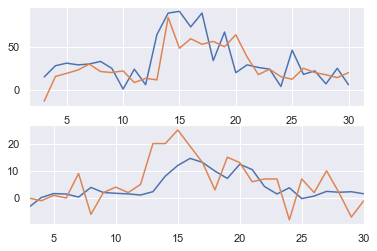

In [126]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

actual_deaths = weekly_deaths_df[weekly_deaths_df['week'] > 2].groupby([ 'week'])['excess_deaths_per100k'].sum()
actual_deaths_df = actual_deaths.to_frame(name = 'actual_excess_deaths').reset_index()
pred_deaths = predicted_df_all_days.groupby(['Week'])['Predicted_Weekly_Excess_Deaths'].sum()
pred_deaths_df = pred_deaths.to_frame(name = 'pred_excess_deaths').reset_index()

fig, axs = plt.subplots(2)
x = actual_deaths_df['week']
y = actual_deaths_df['actual_excess_deaths']
z = pred_deaths_df['pred_excess_deaths']
plt.xlim(3,30)

axs[0].plot(x, y)
axs[0].plot(x, z)

plt.savefig('np_2weeks.png')

x = predicted_df_all_days[predicted_df_all_days['FIPS'] == 8031]['Week']
y = predicted_df_all_days[predicted_df_all_days['FIPS'] == 8031]['Predicted_Weekly_Excess_Deaths']
z = predicted_df_all_days[predicted_df_all_days['FIPS'] == 8031]['Actual_Weekly_Excess_Deaths']

axs[1].plot(x, y)
axs[1].plot(x, z)


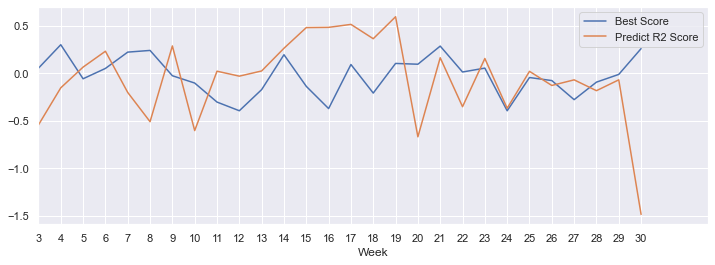

<Figure size 432x288 with 0 Axes>

In [127]:
import seaborn as sns
sns.set()

x = best_fit_scores['Week Duration']
y = best_fit_scores['Best_Score']
z = best_fit_scores['Predict_R2_Score']

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)

plt.xlim(0,30)
plt.xlabel('Week')

ax.plot(x, y, label ='Best Score')

ax.plot(x, z, label ='Predict R2 Score')
plt.legend()
plt.show()
plt.savefig('np_r2_score.png')
#x = weekly_deaths_df[(weekly_deaths_df['county'] == 8031.0) & (weekly_deaths_df['week'] > 4)]['week']
#y = weekly_deaths_df[(weekly_deaths_df['county'] == 8031.0) & (weekly_deaths_df['week'] > 4)]['excess_deaths_per100k']
#z = predicted_df_all_days[(predicted_df_all_days['FIPS'] == 8031.0)]['Predicted_Weekly_Deaths']
#plt.plot(x, y)
#plt.plot(x, z)